In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

/tmp/ipykernel_1473/2151744951.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Load dataset
df = pd.read_csv('/workspaces/quantium/resources/QVI_data.csv')

In [4]:
# Create MONTH column
df['DATE'] = pd.to_datetime(df['DATE'])
df['YEARMONTH'] = df['DATE'].dt.strftime('%Y%m')

In [5]:
# Filter to pre-trial period
pre_trial = df[df['DATE'] < '2019-02-01']

# Get metrics for each store
store_metrics = pre_trial.groupby('STORE_NBR').agg({
    'TOT_SALES': 'sum',
    'LYLTY_CARD_NBR': 'nunique',  # number of unique customers
    'TXN_ID': 'count'  # number of transactions
})

# Filter to stores present throughout pre-trial period
store_metrics = store_metrics.loc[store_metrics['TXN_ID'] > 100]

# Get metrics for trial stores
trial_stores = store_metrics.loc[[77, 86, 88]]

# Find matching control stores
for i, row in trial_stores.iterrows():
    # Find nearest neighbor for each metric
    matches = store_metrics[store_metrics.index != i].assign(
        rev_diff=lambda x: (x['TOT_SALES'] - row['TOT_SALES']).abs(),
        cust_diff=lambda x: (x['LYLTY_CARD_NBR'] - row['LYLTY_CARD_NBR']).abs(),
        txn_diff=lambda x: (x['TXN_ID'] - row['TXN_ID']).abs()
    ).sort_values(by=['rev_diff', 'cust_diff', 'txn_diff'])

    # Select top match as control store
    match_id = matches.index[0]
    print(f"Nearest neighbor for store {i} is {match_id}")


Nearest neighbor for store 77 is 187
Nearest neighbor for store 86 is 13
Nearest neighbor for store 88 is 237


In [6]:
# Calculate metrics
metrics = df.groupby(['STORE_NBR', 'YEARMONTH']).agg({
    'TOT_SALES': 'sum',
    'LYLTY_CARD_NBR': 'nunique',
    'TXN_ID': 'count',
    'PROD_QTY': 'sum',
    'PROD_NAME': lambda x: ((x.str.lower().str.contains('chips')) | (x.str.lower().str.contains('chip'))).sum(),
})

# Sort by store and month
metrics = metrics.sort_values(['STORE_NBR', 'YEARMONTH'])

# Calculate chips per customer
metrics['nChipsPerCust'] = metrics['PROD_NAME'] / np.where(metrics['LYLTY_CARD_NBR'] > 0, metrics['LYLTY_CARD_NBR'], 1)

# Calculate transactions per customer
metrics['nTxnPerCust'] = metrics['TXN_ID'] / np.where(metrics['LYLTY_CARD_NBR'] > 0, metrics['LYLTY_CARD_NBR'], 1)

# Calculate average price per unit
metrics['avgPricePerUnit'] = metrics['TOT_SALES'] / np.where(metrics['PROD_QTY'] > 0, metrics['PROD_QTY'], 1)

In [26]:
metrics

TOT_SALES  LYLTY_CARD_NBR  TXN_ID  PROD_QTY  PROD_NAME  \
STORE_NBR YEARMONTH                                                           
1         201807         206.9              49      52        62         20   
          201808         176.1              42      43        54         14   
          201809         278.8              59      62        75         20   
          201810         188.1              44      45        58         15   
          201811         192.6              46      47        57         19   
...                        ...             ...     ...       ...        ...   
272       201902         395.5              45      48        91         13   
          201903         442.3              50      53       101         13   
          201904         445.1              54      56       105         17   
          201905         314.6              34      40        71         11   
          201906         312.1              34      37        70          5   

                     nChipsPerCust  nTxnPerCust  avgPricePerUnit  
STORE_NBR YEARMONTH                                               
1         201807          0.408163     1.061224         3.337097  
          201808          0.333333     1.023810         3.261111  
          201809          0.338983     1.050847         3.717333  
          201810          0.340909     1.022727         3.243103  
          201811          0.413043     1.021739         3.378947  
...                            ...          ...              ...  
272       201902          0.288889     1.066667         4.346154  
          201903          0.260000     1.060000         4.379208  
          201904          0.314815     1.037037         4.239048  
          201905          0.323529     1.176471         4.430986  
          201906          0.147059     1.088235         4.458571  

[3169 rows x 8 columns]

In [7]:
# Get stores with full data
stores_full_obs = df.groupby('STORE_NBR')['YEARMONTH'].nunique() == 12
stores_full_obs = stores_full_obs[stores_full_obs].index

# Filter pre-trial
pre_trial_metrics = df[
    (df['YEARMONTH'] < '201902') &
    (df['STORE_NBR'].isin(stores_full_obs))
]

In [8]:
print(metrics[['nChipsPerCust', 'nTxnPerCust', 'avgPricePerUnit']])

                     nChipsPerCust  nTxnPerCust  avgPricePerUnit
STORE_NBR YEARMONTH                                             
1         201807          0.408163     1.061224         3.337097
          201808          0.333333     1.023810         3.261111
          201809          0.338983     1.050847         3.717333
          201810          0.340909     1.022727         3.243103
          201811          0.413043     1.021739         3.378947
...                            ...          ...              ...
272       201902          0.288889     1.066667         4.346154
          201903          0.260000     1.060000         4.379208
          201904          0.314815     1.037037         4.239048
          201905          0.323529     1.176471         4.430986
          201906          0.147059     1.088235         4.458571

[3169 rows x 3 columns]


In [9]:
def calculate_correlation(input_table, metric_col, store_comparison):
    # Initialize correlation table
    corr_table = pd.DataFrame(columns=['Store1', 'Store2', 'corr_measure'])
    # Get unique store numbers
    store_numbers = input_table.index.levels[0].unique()

    # Create an empty list to store DataFrames
    dfs_to_concat = []

    # Loop through stores
    for i in store_numbers:
        # Extract time series for stores
        store1 = input_table.loc[store_comparison][metric_col]
        store2 = input_table.loc[i][metric_col]
        # Ensure series
        store1 = pd.Series(store1)
        store2 = pd.Series(store2)
        # Check if there is sufficient variability (avoid constant values)
        if store1.nunique() > 1 and store2.nunique() > 1:
            # Calculate correlation only if there is variability
            corr = store1.corr(store2)
        else:
            # Set correlation to NaN if there is not enough variability
            corr = np.nan
        # Create temp df to append
        tmp_df = pd.DataFrame({
            'Store1': [store_comparison],
            'Store2': [i],
            'corr_measure': [corr]
        })
        # Append the temporary DataFrame to the list
        dfs_to_concat.append(tmp_df)

    # Concatenate all DataFrames in the list
    corr_table = pd.concat(dfs_to_concat, ignore_index=True)

    return corr_table


In [10]:
import pandas as pd
import numpy as np

def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    calc_dist_table = pd.DataFrame(columns=["Store1", "Store2", "YEARMONTH", "measure"])

    store_numbers = input_table['STORE_NBR'].unique()

    for i in store_numbers:
        # Extract time series for the trial store
        value1 = input_table.loc[input_table['STORE_NBR'] == store_comparison, metric_col]
        # Extract time series for the current store
        value2 = input_table.loc[input_table['STORE_NBR'] == i, metric_col]

        # Ensure both series have the same length
        length = min(len(value1), len(value2))
        value1 = value1[:length]
        value2 = value2[:length]

        # Use 'YEARMONTH' from the trial store to ensure consistency
        yeardates = input_table.loc[input_table['STORE_NBR'] == store_comparison, 'YEARMONTH'][:length]

        # Calculate absolute difference
        diff = np.abs(value1.values - value2.values)

        calculated_measure = pd.DataFrame({
            "Store1": [store_comparison] * length,
            "Store2": [i] * length,
            "YEARMONTH": yeardates,
            "measure": diff
        })

        calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)

    min_max_dist = calc_dist_table.groupby(["Store1", "YEARMONTH"])['measure'].agg(['min', 'max']).reset_index()
    dist_table = pd.merge(calc_dist_table, min_max_dist, on=["Store1", "YEARMONTH"])
    dist_table['magnitudeMeasure'] = 1 - (dist_table['measure'] - dist_table['min']) / (
            dist_table['max'] - dist_table['min'])

    final_dist_table = dist_table.groupby(["Store1", "Store2"])['magnitudeMeasure'].mean().reset_index()
    final_dist_table.rename(columns={'magnitudeMeasure': 'mag_measure'}, inplace=True)

    return final_dist_table


In [11]:
def standardize_magnitude_distance(magnitude_distances):
    min_max_dist = magnitude_distances.groupby(['Store1', 'YEARMONTH'])['mag_measure'].agg(['min', 'max']).reset_index()
    magnitude_distances = pd.merge(magnitude_distances, min_max_dist, on=['Store1', 'YEARMONTH'])
    magnitude_distances['magnitudeMeasure'] = (magnitude_distances['mag_measure'] - magnitude_distances['min']) / (
            magnitude_distances['max'] - magnitude_distances['min'])

    final_magnitude_distances = magnitude_distances.groupby(['Store1', 'Store2'])['magnitudeMeasure'].mean().reset_index()
    final_magnitude_distances.rename(columns={'magnitudeMeasure': 'mag_measure'}, inplace=True)

    return final_magnitude_distances

In [12]:
# Set trial stores
trial_stores = [77, 86, 88]

for trial_store in trial_stores:
    # Calculate correlations for TOT_SALES, LYLTY_CARD_NBR, and nTxnPerCust
    corr_nSales = calculate_correlation(input_table=metrics, metric_col='TOT_SALES', store_comparison=trial_store)
    corr_nCustomers = calculate_correlation(input_table=metrics, metric_col='LYLTY_CARD_NBR', store_comparison=trial_store)
    corr_nTxnPerCust = calculate_correlation(input_table=metrics, metric_col='nTxnPerCust', store_comparison=trial_store)
    
    # Combine the correlation measures
    corr_combined = pd.DataFrame({
        'Store2': corr_nSales['Store2'],
        'corr_combined': (corr_nSales['corr_measure'] + corr_nCustomers['corr_measure'] + corr_nTxnPerCust['corr_measure']) / 3
    })
    
    # Exclude trial store from consideration
    corr_combined = corr_combined[corr_combined['Store2'] != trial_store]
    
    # Find the store with the highest combined correlation
    most_correlated_store = int(corr_combined.loc[corr_combined['corr_combined'].idxmax()]['Store2'])
    
    print(f"Most correlated store with trial store {trial_store} is {most_correlated_store}")


Most correlated store with trial store 77 is 115
Most correlated store with trial store 86 is 260
Most correlated store with trial store 88 is 201


In [13]:
# Set trial stores
trial_stores = [77]

for trial_store in trial_stores:
    # Reset index and drop the existing 'level_0' column
    pre_trial_metrics = pre_trial_metrics.reset_index(drop=True)

    # Calculate magnitude distances
    magnitude_nSales = calculate_magnitude_distance(input_table=pre_trial_metrics, metric_col='TOT_SALES', store_comparison=trial_store)
    magnitude_nCustomers = calculate_magnitude_distance(input_table=pre_trial_metrics, metric_col='LYLTY_CARD_NBR', store_comparison=trial_store)

    # Display the resulting DataFrames
    print(f"\nMagnitude distances for trial store {trial_store} - TOT_SALES:")
    print(magnitude_nSales)

    print(f"\nMagnitude distances for trial store {trial_store} - LYLTY_CARD_NBR:")
    print(magnitude_nCustomers)


/tmp/ipykernel_1473/3517640779.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  calc_dist_table = pd.concat([calc_dist_table, calculated_measure], ignore_index=True)



Magnitude distances for trial store 77 - TOT_SALES:
     Store1  Store2  mag_measure
0        77       1     0.879485
1        77       2     0.875391
2        77       3     0.825645
3        77       4     0.823444
4        77       5     0.856677
..      ...     ...          ...
255      77     268     0.874479
256      77     269     0.864833
257      77     270     0.859161
258      77     271     0.863603
259      77     272     0.827211

[260 rows x 3 columns]

Magnitude distances for trial store 77 - LYLTY_CARD_NBR:
     Store1  Store2 mag_measure
0        77       1    0.725517
1        77       2    0.765193
2        77       3    0.730994
3        77       4    0.733983
4        77       5    0.736966
..      ...     ...         ...
255      77     268    0.387382
256      77     269    0.385027
257      77     270    0.382062
258      77     271    0.379065
259      77     272    0.375667

[260 rows x 3 columns]


In [14]:
# Merge correlation and magnitude tables for TOT_SALES
combined_score_nSales = pd.merge(corr_nSales, magnitude_nSales, on=['Store1', 'Store2'], how='outer')

# Fill NaN values with appropriate default values
combined_score_nSales = combined_score_nSales.fillna(0).infer_objects(copy=False)

# Calculate combined score for TOT_SALES
corr_weight_nSales = 0.5
combined_score_nSales['scoreNSales'] = corr_weight_nSales * combined_score_nSales['corr_measure'] + (1 - corr_weight_nSales) * combined_score_nSales['mag_measure']

# Merge correlation and magnitude tables for LYLTY_CARD_NBR
combined_score_nCustomers = pd.merge(corr_nCustomers, magnitude_nCustomers, on=['Store1', 'Store2'], how='outer')

# Fill NaN values with appropriate default values
combined_score_nCustomers = combined_score_nCustomers.fillna(0).infer_objects(copy=False)

# Calculate combined score for LYLTY_CARD_NBR
corr_weight_nCustomers = 0.5
combined_score_nCustomers['scoreNCust'] = corr_weight_nCustomers * combined_score_nCustomers['corr_measure'] + (1 - corr_weight_nCustomers) * combined_score_nCustomers['mag_measure']

# Merge scores for TOT_SALES and LYLTY_CARD_NBR
combined_scores = pd.merge(combined_score_nSales, combined_score_nCustomers, on=['Store1', 'Store2'])

# Calculate the final control score
combined_scores['finalControlScore'] = 0.5 * combined_scores['scoreNSales'] + 0.5 * combined_scores['scoreNCust']


/tmp/ipykernel_1473/243043212.py:15: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_score_nCustomers = combined_score_nCustomers.fillna(0).infer_objects(copy=False)


In [15]:
# List of trial stores to exclude
trial_stores_to_exclude = [77, 86, 88]

# Calculate the final control score
combined_scores['finalControlScore'] = 0.5 * combined_scores['scoreNSales'] + 0.5 * combined_scores['scoreNCust']

# Exclude the trial stores from consideration
filtered_scores = combined_scores[~combined_scores['Store2'].isin(trial_stores_to_exclude)]

# Sort the stores based on the final control score in descending order
sorted_scores = filtered_scores.sort_values(by='finalControlScore', ascending=False)

# Get the top 5 control store candidates
top_control_stores = sorted_scores.head(5)['Store2'].tolist()

# Print the top control store candidates
print("Top 5 Control Store Candidates:", top_control_stores)

# Store the number 1 value from the candidates array in control_store
control_store = top_control_stores[0]


Top 5 Control Store Candidates: [74, 78, 90, 98, 61]


In [16]:
trial_store

77

In [20]:
# Convert trial_store to a list
trial_store = [trial_store]

# Create a new 'Store_type' column with default value 'Other stores'
df['Store_type'] = 'Other stores'

# Update the 'Store_type' column for trial and control stores
df.loc[df['STORE_NBR'].isin(trial_store), 'Store_type'] = 'Trial'
df.loc[df['STORE_NBR'] == control_store, 'Store_type'] = 'Control'

# Create a 'totSales' column
df['totSales'] = df.groupby(['YEARMONTH', 'Store_type'])['TOT_SALES'].transform('mean')

# Calculate mean total sales by month and store type
pastSales = df.groupby(['YEARMONTH', 'Store_type'], as_index=False)['totSales'].mean()


In [21]:
df

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER,YEARMONTH,Store_type,totSales
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium,201810,Other stores,7.386560
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream,201809,Other stores,7.393295
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget,201903,Other stores,7.370224
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget,201903,Other stores,7.370224
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream,201811,Other stores,7.341214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
264829,2370701,2018-12-08,88,240378,24,Grain Waves Sweet Chilli 210g,2,7.2,210,GRNWVES,YOUNG FAMILIES,Mainstream,201812,Other stores,7.362848
264830,2370751,2018-10-01,88,240394,60,Kettle Tortilla ChpsFeta&Garlic 150g,2,9.2,150,KETTLE,YOUNG FAMILIES,Premium,201810,Other stores,7.386560
264831,2370961,2018-10-24,88,240480,70,Tyrrells Crisps Lightly Salted 165g,2,8.4,165,TYRRELLS,OLDER FAMILIES,Budget,201810,Other stores,7.386560
264832,2370961,2018-10-27,88,240481,65,Old El Paso Salsa Dip Chnky Tom Ht300g,2,10.2,300,OLD,OLDER FAMILIES,Budget,201810,Other stores,7.386560


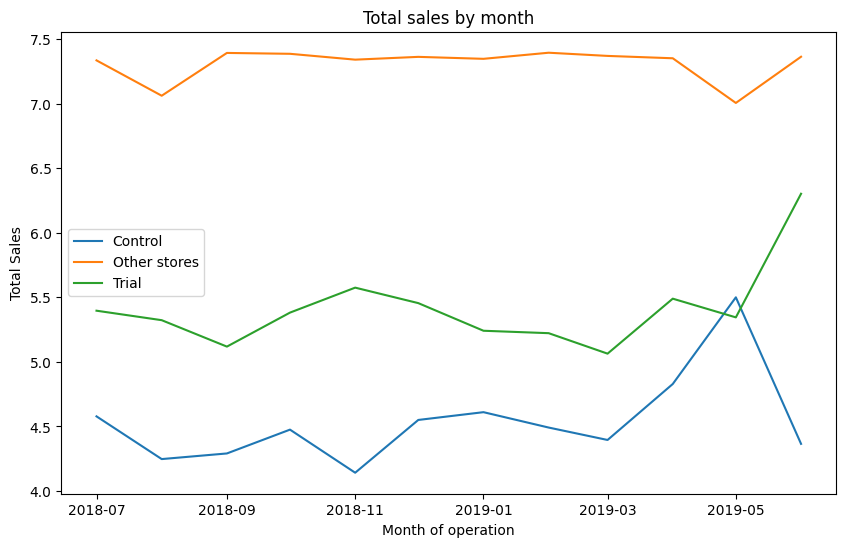

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named df with columns: YEARMONTH, STORE_NBR, TOT_SALES, Store_type
# Create a new 'Store_type' column with default value 'Other stores'
df['Store_type'] = 'Other stores'

# Update the 'Store_type' column for trial and control stores
df.loc[df['STORE_NBR'].isin(trial_store), 'Store_type'] = 'Trial'
df.loc[df['STORE_NBR'] == control_store, 'Store_type'] = 'Control'

# Create a 'totSales' column (assuming it's the total sales column)
df['totSales'] = df.groupby(['YEARMONTH', 'Store_type'])['TOT_SALES'].transform('mean')

# Calculate mean total sales by month and store type
pastSales = df.groupby(['YEARMONTH', 'Store_type'], as_index=False)['totSales'].mean()

# Convert TransactionMonth to datetime format
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'], format='%Y%m')

# Plotting lines for each store type
plt.figure(figsize=(10, 6))
for store_type in pastSales['Store_type'].unique():
    store_data = pastSales[pastSales['Store_type'] == store_type]
    plt.plot(store_data['TransactionMonth'], store_data['totSales'], label=store_type)

plt.xlabel('Month of operation')
plt.ylabel('Total Sales')
plt.title('Total sales by month')
plt.legend()
plt.show()


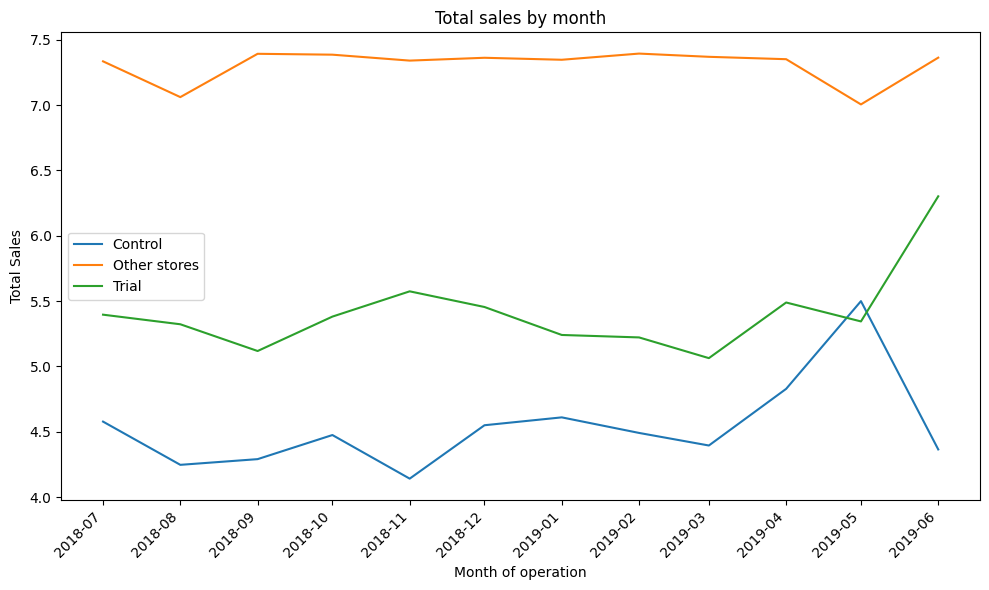

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have a DataFrame named df with columns: YEARMONTH, STORE_NBR, TOT_SALES, Store_type
# Create a new 'Store_type' column with default value 'Other stores'
df['Store_type'] = 'Other stores'

# Update the 'Store_type' column for trial and control stores
df.loc[df['STORE_NBR'].isin(trial_store), 'Store_type'] = 'Trial'
df.loc[df['STORE_NBR'] == control_store, 'Store_type'] = 'Control'

# Create a 'totSales' column (assuming it's the total sales column)
df['totSales'] = df.groupby(['YEARMONTH', 'Store_type'])['TOT_SALES'].transform('mean')

# Calculate mean total sales by month and store type
pastSales = df.groupby(['YEARMONTH', 'Store_type'], as_index=False)['totSales'].mean()

# Convert TransactionMonth to datetime format
pastSales['TransactionMonth'] = pd.to_datetime(pastSales['YEARMONTH'], format='%Y%m')

# Ensure all months are included in the plot
min_month = pastSales['TransactionMonth'].min()
max_month = pastSales['TransactionMonth'].max()
all_months = pd.date_range(start=min_month, end=max_month, freq='MS')

# Plotting lines for each store type
plt.figure(figsize=(10, 6))
for store_type in pastSales['Store_type'].unique():
    store_data = pastSales[pastSales['Store_type'] == store_type]
    plt.plot(store_data['TransactionMonth'], store_data['totSales'], label=store_type)

# Ensure all months are included on the x-axis
plt.xticks(all_months, all_months.strftime('%Y-%m'), rotation=45, ha='right')

plt.xlabel('Month of operation')
plt.ylabel('Total Sales')
plt.title('Total sales by month')
plt.legend()
plt.tight_layout()
plt.show()


In [28]:
# Plotting lines for each store type
plt.figure(figsize=(10, 6))
for store_type in metrics['Store_type'].unique():
    store_data = metrics[metrics['Store_type'] == store_type]
    plt.plot(store_data['TransactionMonth'], store_data['TOT_SALES'], label=store_type)

plt.xlabel('Month of operation')
plt.ylabel('Total Sales')
plt.title('Total sales by month')
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'Store_type'

<Figure size 1000x600 with 0 Axes>